In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download("AAPL", start="2015-01-01")
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # 'B' indicates business days
data = data.ffill().dropna()  # Forward fill NaN values and drop remaining NaNs

[*********************100%%**********************]  1 of 1 completed


# PROPHET

13:01:09 - cmdstanpy - INFO - Chain [1] start processing
13:01:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


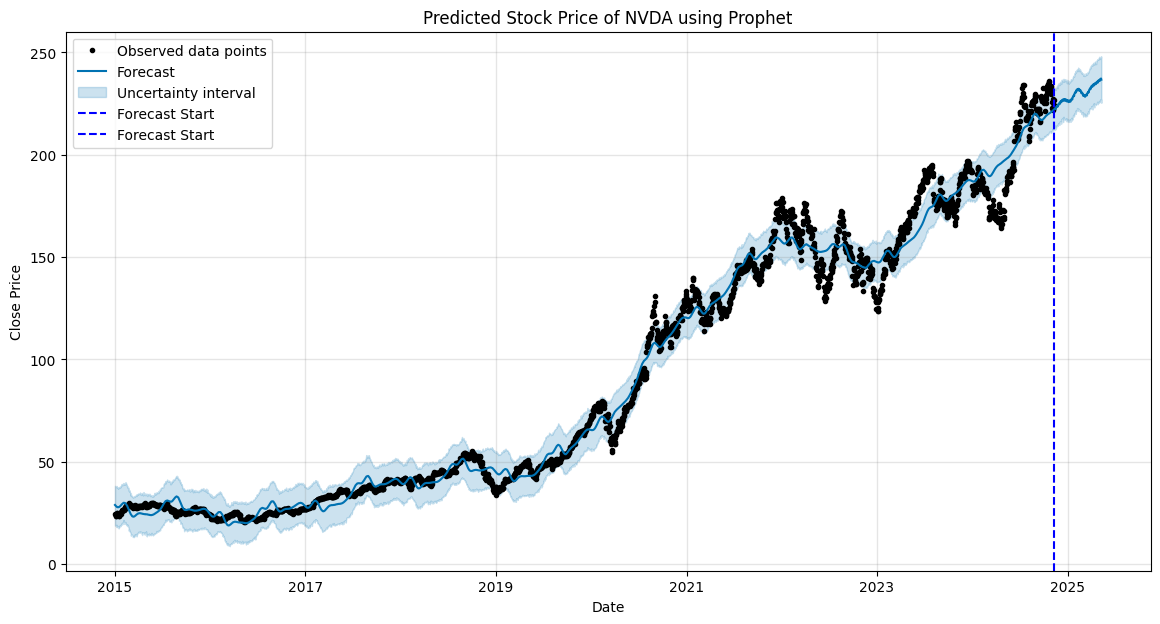

In [4]:
from models.prophet_model import Prophet

# Prepare the Data for Prophet
data_prophet = data.reset_index()
data_prophet = data_prophet.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

# Create and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(data_prophet)

# Create future dataframe for the next 3 months (90 days)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot predictions
fig, ax = plt.subplots(figsize=(14, 7))
model.plot(forecast, ax=ax)
ax.set_title("Predicted Stock Price of NVDA using Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close Price")

# Add vertical line for forecast start
forecast_start_date = data_prophet['ds'].iloc[-1]
ax.axvline(x=forecast_start_date, color='blue', linestyle='--', label='Forecast Start')

# Manually add legend for forecast start
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='blue', linestyle='--'))
labels.append('Forecast Start')
ax.legend(handles=handles, labels=labels)

plt.show()


# ML MODELS
## XGBoost Model

Without rolling

[*********************100%%**********************]  1 of 1 completed

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


XGBoost Model Test MSE: 329.87
XGBoost Model Test MAE: 14.39


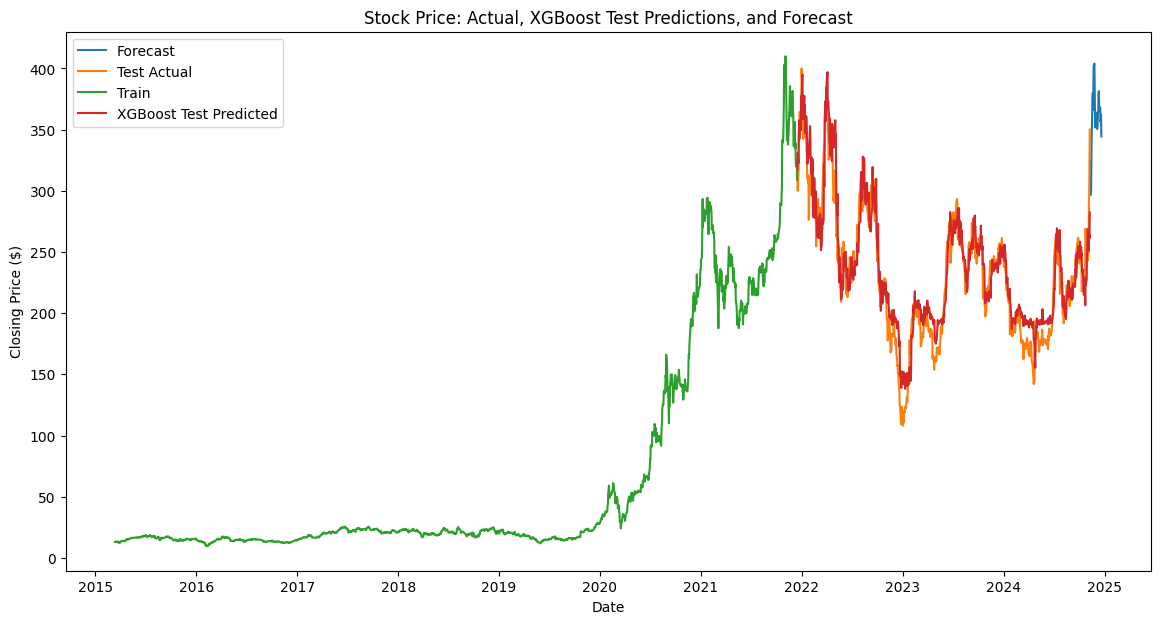

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Data Acquisition and Preprocessing

# Download historical data
stock_name = "tsla"
df = yf.download(stock_name, start="2015-01-01")

# Ensure the index is a datetime object and set business day frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')

# Forward fill missing values
df = df.ffill().dropna()

# Step 2: Feature Engineering

# Calculate Returns before shifting 'Close'
df['Returns'] = df['Adj Close'].pct_change()

# Feature engineering
df['EMA_9'] = df['Adj Close'].ewm(span=9, adjust=False).mean().shift(1)
df['SMA_5'] = df['Adj Close'].rolling(window=5).mean().shift(1)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean().shift(1)
df['SMA_15'] = df['Adj Close'].rolling(window=15).mean().shift(1)
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean().shift(1)
df['SMA_50'] = df['Adj Close'].rolling(window=50).mean().shift(1)

# Shift Close for next-day prediction
df['Adj Close'] = df['Adj Close'].shift(-1)

# Drop rows with NaN values
df = df.dropna()

# Step 3: Train-Test Split

# Calculate the split index
train_size = int(len(df) * 0.7)

# Split the data
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Step 4: Prepare Data for XGBoost

# Define the feature columns
feature_cols = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'SMA_50', 'Returns']

# Features and target for training
X_train = train_df[feature_cols]
y_train = train_df['Adj Close']

# Features and target for testing
X_test = test_df[feature_cols]
y_test = test_df['Adj Close']

# Handle potential missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target for XGBoost
y_train_log = np.log(y_train)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Instantiate the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train_log)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 5: Predict on Test Set with XGBoost only
y_pred_log_xgb = best_model.predict(X_test_scaled)

# Transform Predictions Back to Original Scale
y_pred_test = np.exp(y_pred_log_xgb)

# Step 6: Evaluate the XGBoost Model on Test Set
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
print(f"XGBoost Model Test MSE: {mse:.2f}")
print(f"XGBoost Model Test MAE: {mae:.2f}")

# Step 7: Forecast 30 Days Ahead with XGBoost Only

# Initialize the forecast input with the last available data in the test set
forecast_input = test_df.copy()
forecast_df = pd.DataFrame(columns=df.columns)

# Forecast 30 days ahead starting from the end of the test set
for i in range(30):
    last_date = forecast_input.index[-1]
    next_date = last_date + pd.offsets.BDay(1)
    
    last_close = forecast_input['Adj Close'].iloc[-1]
    
    ema_9 = forecast_input['Adj Close'].ewm(span=9, adjust=False).mean().iloc[-1]
    sma_5 = forecast_input['Adj Close'].rolling(window=5).mean().iloc[-1]
    sma_10 = forecast_input['Adj Close'].rolling(window=10).mean().iloc[-1]
    sma_15 = forecast_input['Adj Close'].rolling(window=15).mean().iloc[-1]
    sma_30 = forecast_input['Adj Close'].rolling(window=30).mean().iloc[-1]
    sma_50 = forecast_input['Adj Close'].rolling(window=50).mean().iloc[-1]
    returns = forecast_input['Returns'].iloc[-1]
    
    # Define features for the next day
    feature_row = {
        'EMA_9': ema_9,
        'SMA_5': sma_5,
        'SMA_10': sma_10,
        'SMA_15': sma_15,
        'SMA_30': sma_30,
        'SMA_50': sma_50,
        'Returns': returns
    }
    
    # Prepare input for the forecast model
    input_features = pd.DataFrame([feature_row], index=[next_date], columns=feature_cols)
    input_features = input_features.fillna(0)
    input_scaled = scaler.transform(input_features)
    
    # Predict using the XGBoost model
    pred_log_xgb = best_model.predict(input_scaled)
    predicted_close = np.exp(pred_log_xgb)
    
    # Update the feature row with forecasted values
    feature_row['Adj Close'] = predicted_close
    feature_row['Log_Close'] = np.log(predicted_close)
    feature_row['Returns'] = (predicted_close - last_close) / last_close
    
    # Append the forecasted row to the forecast data and update forecast input for the next iteration
    forecast_input = pd.concat([forecast_input, pd.DataFrame(feature_row, index=[next_date])])
    forecast_df = pd.concat([forecast_df, pd.DataFrame(feature_row, index=[next_date])])

# Plotting to Compare Test Predictions and Forecasts

# DataFrames for plotting
train_df_plot = train_df[['Adj Close']].copy()
train_df_plot['Dataset'] = 'Train'
test_actual_df = test_df[['Adj Close']].copy()
test_actual_df['Dataset'] = 'Test Actual'
test_pred_df = pd.DataFrame({'Adj Close': y_pred_test}, index=y_test.index)
test_pred_df['Dataset'] = 'XGBoost Test Predicted'
forecast_df['Dataset'] = 'Forecast'

plot_df = pd.concat([
    train_df_plot[['Adj Close', 'Dataset']],
    test_actual_df[['Adj Close', 'Dataset']],
    test_pred_df[['Adj Close', 'Dataset']],
    forecast_df[['Adj Close', 'Dataset']]
])

# Plotting
plt.figure(figsize=(14, 7))
for label, group in plot_df.groupby('Dataset'):
    plt.plot(group.index, group['Adj Close'], label=label)
plt.title('Stock Price: Actual, XGBoost Test Predictions, and Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

CON ROLLING en test y forecast Y STARTING CON LAST ACTUAL PRICE

[*********************100%%**********************]  1 of 1 completed


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


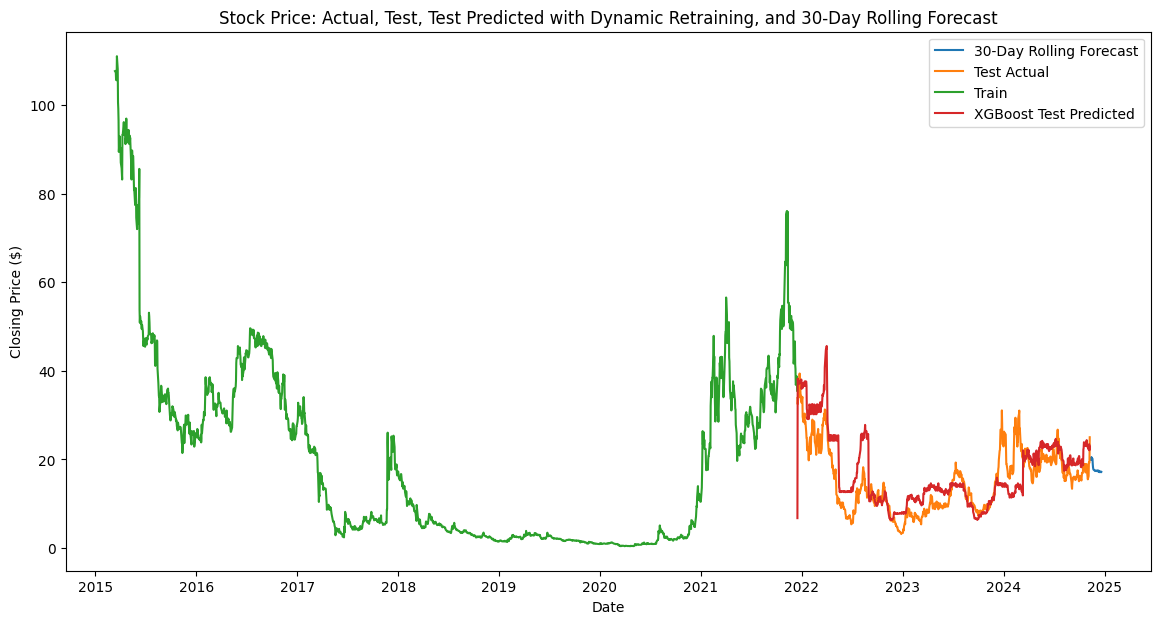

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Data Acquisition and Preprocessing

# Download historical data
stock_name = "MARA"
df = yf.download(stock_name, start="2015-01-01")

# Ensure the index is a datetime object and set business day frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')

# Forward fill missing values
df = df.ffill().dropna()

# Step 2: Feature Engineering

# Calculate Returns before shifting 'Close'
df['Returns'] = df['Adj Close'].pct_change()

# Feature engineering
df['EMA_9'] = df['Adj Close'].ewm(span=9, adjust=False).mean().shift(1)
df['SMA_5'] = df['Adj Close'].rolling(window=5).mean().shift(1)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean().shift(1)
df['SMA_15'] = df['Adj Close'].rolling(window=15).mean().shift(1)
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean().shift(1)
df['SMA_50'] = df['Adj Close'].rolling(window=50).mean().shift(1)

# Shift Close for next-day prediction
df['Adj Close'] = df['Adj Close'].shift(-1)

# Drop rows with NaN values
df = df.dropna()

# Step 3: Train-Test Split

# Calculate the split index
train_size = int(len(df) * 0.7)

# Split the data
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Step 4: Prepare Data for XGBoost

# Define the feature columns
feature_cols = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'SMA_50', 'Returns']

# Features and target for training
X_train = train_df[feature_cols]
y_train = train_df['Adj Close']

# Features and target for testing
X_test = test_df[feature_cols]
y_test = test_df['Adj Close']

# Handle potential missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target for XGBoost
y_train_log = np.log(y_train)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Instantiate the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train_log)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 5: Rolling Window Evaluation and Prediction on Test Set

# Set a threshold for MSE; if exceeded, retrain the model
mse_threshold = 70  # Adjust based on your error tolerance
window_size = 90     # Number of days in each rolling window for training

test_predicted = []  # Store predictions for the test set

for i in range(len(X_test)):
    # Select the rolling window of recent data
    rolling_train_df = pd.concat([train_df, test_df.iloc[:i]])[-window_size:]
    X_rolling_train = rolling_train_df[feature_cols]
    y_rolling_train = rolling_train_df['Adj Close']
    
    # Scale the data
    X_rolling_train_scaled = scaler.fit_transform(X_rolling_train.fillna(0))
    y_rolling_train_log = np.log(y_rolling_train)
    
    # Retrain the model on the recent window if the rolling MSE exceeds the threshold
    if i > 0 and mse > mse_threshold:
        best_model.fit(X_rolling_train_scaled, y_rolling_train_log)
    
    # Predict the next point in the test set
    X_test_scaled_point = scaler.transform(X_test.iloc[[i]].fillna(0))
    y_pred_log_xgb = best_model.predict(X_test_scaled_point)
    y_pred_test_point = np.exp(y_pred_log_xgb)[0]  # Convert log prediction to original scale
    
    test_predicted.append(y_pred_test_point)
    
    # Update MSE for the rolling window
    if i >= window_size:
        mse = mean_squared_error(y_test.iloc[i-window_size+1:i+1], test_predicted[-window_size:])
    else:
        mse = mean_squared_error(y_test.iloc[:i+1], test_predicted)

# Step 6: 30-Day Rolling Forecast Beyond Test Set

rolling_forecast = []
current_input = test_df.copy()

# Forecast 30 days ahead after the test set
for i in range(30):
    # Use the most recent `window_size` days to retrain the model
    rolling_train_df = current_input.iloc[-window_size:]
    X_rolling_train = rolling_train_df[feature_cols]
    y_rolling_train = rolling_train_df['Adj Close']
    
    # Scale the rolling train data
    X_rolling_train_scaled = scaler.fit_transform(X_rolling_train.fillna(0))
    y_rolling_train_log = np.log(y_rolling_train)
    
    # Fit the XGBoost model on the rolling window data
    best_model.fit(X_rolling_train_scaled, y_rolling_train_log)
    
    # Prepare features for the next day's prediction
    last_close = current_input['Adj Close'].iloc[-1]
    ema_9 = current_input['Adj Close'].ewm(span=9, adjust=False).mean().iloc[-1]
    sma_5 = current_input['Adj Close'].rolling(window=5).mean().iloc[-1]
    sma_10 = current_input['Adj Close'].rolling(window=10).mean().iloc[-1]
    sma_15 = current_input['Adj Close'].rolling(window=15).mean().iloc[-1]
    sma_30 = current_input['Adj Close'].rolling(window=30).mean().iloc[-1]
    sma_50 = current_input['Adj Close'].rolling(window=50).mean().iloc[-1]
    returns = current_input['Returns'].iloc[-1]
    
    # Define features for the next day
    feature_row = {
        'EMA_9': ema_9,
        'SMA_5': sma_5,
        'SMA_10': sma_10,
        'SMA_15': sma_15,
        'SMA_30': sma_30,
        'SMA_50': sma_50,
        'Returns': returns
    }
    
    # Prepare input for the forecast model
    input_features = pd.DataFrame([feature_row], columns=feature_cols)
    input_scaled = scaler.transform(input_features.fillna(0))
    
    # Predict using the XGBoost model
    pred_log_xgb = best_model.predict(input_scaled)
    predicted_close = np.exp(pred_log_xgb)[0]  # Convert log prediction to original scale
    
    # Append the forecasted close price
    rolling_forecast.append(predicted_close)
    
    # Update the current input with the new prediction
    next_date = current_input.index[-1] + pd.offsets.BDay(1)
    new_row = pd.DataFrame(
        {'Adj Close': [predicted_close], 'Returns': [(predicted_close - last_close) / last_close]},
        index=[next_date]
    )
    for col, value in feature_row.items():
        new_row[col] = value  # Copy the feature values for consistency
    
    current_input = pd.concat([current_input, new_row])

# Step 7: Plot the Test Predictions and Rolling Forecast Results

# DataFrames for plotting
train_df_plot = train_df[['Adj Close']].copy()
train_df_plot['Dataset'] = 'Train'
test_actual_df = test_df[['Adj Close']].copy()
test_actual_df['Dataset'] = 'Test Actual'
test_pred_df = pd.DataFrame({'Adj Close': test_predicted}, index=y_test.index)
test_pred_df['Dataset'] = 'XGBoost Test Predicted'
rolling_forecast_df = pd.DataFrame({'Adj Close': rolling_forecast}, index=current_input.index[-30:])
rolling_forecast_df['Dataset'] = '30-Day Rolling Forecast'

plot_df = pd.concat([
    train_df_plot[['Adj Close', 'Dataset']],
    test_actual_df[['Adj Close', 'Dataset']],
    test_pred_df[['Adj Close', 'Dataset']],
    rolling_forecast_df[['Adj Close', 'Dataset']]
])

# Plotting
plt.figure(figsize=(14, 7))
for label, group in plot_df.groupby('Dataset'):
    plt.plot(group.index, group['Adj Close'], label=label)
plt.title('Stock Price: Actual, Test, Test Predicted with Dynamic Retraining, and 30-Day Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


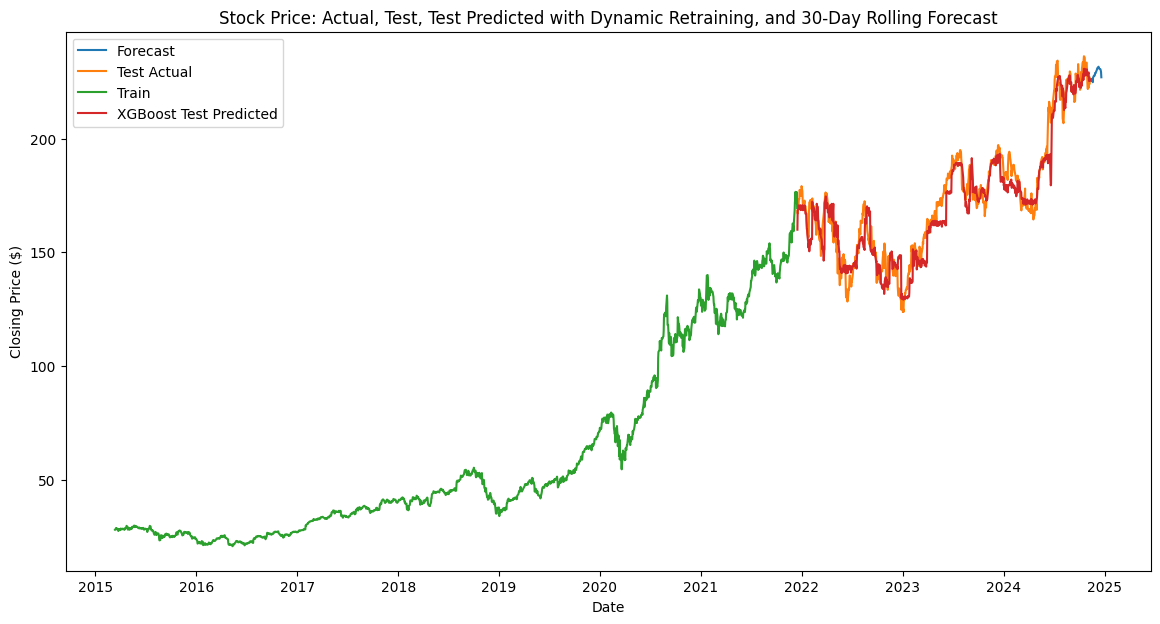

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# List of stocks for each approach
first_code_stocks = ["AMZN", "ASML", "TSLA", "MARA", "RIOT", "NFLX"]
second_code_stocks = ["AAPL", "MSFT", "NVDA", "GOOGL"]

# Set the stock you want to analyze
stock_name = "AAPL"  # Replace with the desired stock

# Step 1: Data Acquisition and Preprocessing
# Download historical data
df = yf.download(stock_name, start="2015-01-01")

# Ensure the index is a datetime object and set business day frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')

# Forward fill missing values
df = df.ffill().dropna()

# Step 2: Feature Engineering
# Calculate Returns before shifting 'Close'
df['Returns'] = df['Adj Close'].pct_change()

# Feature engineering
df['EMA_9'] = df['Adj Close'].ewm(span=9, adjust=False).mean().shift(1)
df['SMA_5'] = df['Adj Close'].rolling(window=5).mean().shift(1)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean().shift(1)
df['SMA_15'] = df['Adj Close'].rolling(window=15).mean().shift(1)
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean().shift(1)
df['SMA_50'] = df['Adj Close'].rolling(window=50).mean().shift(1)

# Shift Close for next-day prediction
df['Adj Close'] = df['Adj Close'].shift(-1)

# Drop rows with NaN values
df = df.dropna()

# Step 3: Train-Test Split
# Calculate the split index
train_size = int(len(df) * 0.7)

# Split the data
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Step 4: Prepare Data for XGBoost
# Define the feature columns
feature_cols = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'SMA_50', 'Returns']

# Features and target for training
X_train = train_df[feature_cols]
y_train = train_df['Adj Close']

# Features and target for testing
X_test = test_df[feature_cols]
y_test = test_df['Adj Close']

# Handle potential missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target for XGBoost
y_train_log = np.log(y_train)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Instantiate the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train_log)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Check which approach to use
if stock_name in first_code_stocks:
    # Approach 1: Without rolling window (First Code)

    # Predict on Test Set with XGBoost only
    y_pred_log_xgb = best_model.predict(X_test_scaled)

    # Transform Predictions Back to Original Scale
    y_pred_test = np.exp(y_pred_log_xgb)

    # Evaluate the XGBoost Model on Test Set
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    print(f"XGBoost Model Test MSE: {mse:.2f}")
    print(f"XGBoost Model Test MAE: {mae:.2f}")

    # 30-Day Forecast
    forecast_input = test_df.copy()
    forecast_df = pd.DataFrame(columns=df.columns)

    for i in range(30):
        last_date = forecast_input.index[-1]
        next_date = last_date + pd.offsets.BDay(1)
        last_close = forecast_input['Adj Close'].iloc[-1]
        
        # Calculate features based only on actual prices
        ema_9 = forecast_input['Adj Close'].ewm(span=9, adjust=False).mean().iloc[-1]
        sma_5 = forecast_input['Adj Close'].rolling(window=5).mean().iloc[-1]
        sma_10 = forecast_input['Adj Close'].rolling(window=10).mean().iloc[-1]
        sma_15 = forecast_input['Adj Close'].rolling(window=15).mean().iloc[-1]
        sma_30 = forecast_input['Adj Close'].rolling(window=30).mean().iloc[-1]
        sma_50 = forecast_input['Adj Close'].rolling(window=50).mean().iloc[-1]
        returns = forecast_input['Returns'].iloc[-1]

        # Define features for the next day
        feature_row = {
            'EMA_9': ema_9, 'SMA_5': sma_5, 'SMA_10': sma_10,
            'SMA_15': sma_15, 'SMA_30': sma_30, 'SMA_50': sma_50, 'Returns': returns
        }
        
        input_features = pd.DataFrame([feature_row], index=[next_date], columns=feature_cols)
        input_features = input_features.fillna(0)
        input_scaled = scaler.transform(input_features.fillna(0))
        
        # Predict
        pred_log_xgb = best_model.predict(input_scaled)
        predicted_close = np.exp(pred_log_xgb)

        feature_row['Adj Close'] = predicted_close
        feature_row['Log_Close'] = np.log(predicted_close)
        feature_row['Returns'] = (predicted_close - last_close) / last_close

        forecast_input = pd.concat([forecast_input, pd.DataFrame(feature_row, index=[next_date])])
        forecast_df = pd.concat([forecast_df, pd.DataFrame(feature_row, index=[next_date])])
    
elif stock_name in second_code_stocks:
    # Approach 2: With rolling window (Second Code)
    mse_threshold = 70
    window_size = 90

    y_pred_test = []

    for i in range(len(X_test)):
        rolling_train_df = pd.concat([train_df, test_df.iloc[:i]])[-window_size:]
        X_rolling_train = rolling_train_df[feature_cols]
        y_rolling_train = rolling_train_df['Adj Close']

        X_rolling_train_scaled = scaler.fit_transform(X_rolling_train.fillna(0))
        y_rolling_train_log = np.log(y_rolling_train)

        if i > 0 and mse > mse_threshold:
            best_model.fit(X_rolling_train_scaled, y_rolling_train_log)

        X_test_scaled_point = scaler.transform(X_test.iloc[[i]].fillna(0))
        y_pred_log_xgb = best_model.predict(X_test_scaled_point)
        y_pred_test_point = np.exp(y_pred_log_xgb)[0]
        
        y_pred_test.append(y_pred_test_point)

        if i >= window_size:
            mse = mean_squared_error(y_test.iloc[i-window_size+1:i+1], y_pred_test[-window_size:])
        else:
            mse = mean_squared_error(y_test.iloc[:i+1], y_pred_test)

    rolling_forecast = []
    current_input = test_df.copy()

    for i in range(30):
        rolling_train_df = current_input.iloc[-window_size:]
        X_rolling_train = rolling_train_df[feature_cols]
        y_rolling_train = rolling_train_df['Adj Close']

        X_rolling_train_scaled = scaler.fit_transform(X_rolling_train.fillna(0))
        y_rolling_train_log = np.log(y_rolling_train)

        best_model.fit(X_rolling_train_scaled, y_rolling_train_log)

        last_close = current_input['Adj Close'].iloc[-1]
        ema_9 = current_input['Adj Close'].ewm(span=9, adjust=False).mean().iloc[-1]
        sma_5 = current_input['Adj Close'].rolling(window=5).mean().iloc[-1]
        sma_10 = current_input['Adj Close'].rolling(window=10).mean().iloc[-1]
        sma_15 = current_input['Adj Close'].rolling(window=15).mean().iloc[-1]
        sma_30 = current_input['Adj Close'].rolling(window=30).mean().iloc[-1]
        sma_50 = current_input['Adj Close'].rolling(window=50).mean().iloc[-1]
        returns = current_input['Returns'].iloc[-1]
        
        feature_row = {
            'EMA_9': ema_9, 'SMA_5': sma_5, 'SMA_10': sma_10,
            'SMA_15': sma_15, 'SMA_30': sma_30, 'SMA_50': sma_50, 'Returns': returns
        }

        input_features = pd.DataFrame([feature_row], columns=feature_cols)
        input_scaled = scaler.transform(input_features.fillna(0))

        pred_log_xgb = best_model.predict(input_scaled)
        predicted_close = np.exp(pred_log_xgb)[0]
        
        rolling_forecast.append(predicted_close)

        next_date = current_input.index[-1] + pd.offsets.BDay(1)
        new_row = pd.DataFrame({'Adj Close': [predicted_close], 'Returns': [(predicted_close - last_close) / last_close]}, index=[next_date])
        
        for col, value in feature_row.items():
            new_row[col] = value
        current_input = pd.concat([current_input, new_row])
    
    forecast_df = pd.DataFrame({'Adj Close': rolling_forecast}, index=current_input.index[-30:])


train_df_plot = train_df[['Adj Close']].copy()
train_df_plot['Dataset'] = 'Train'
test_actual_df = test_df[['Adj Close']].copy()
test_actual_df['Dataset'] = 'Test Actual'
test_pred_df = pd.DataFrame({'Adj Close': y_pred_test}, index=y_test.index)
test_pred_df['Dataset'] = 'XGBoost Test Predicted'
forecast_df['Dataset'] = 'Forecast'

plot_df = pd.concat([
    train_df_plot[['Adj Close', 'Dataset']],
    test_actual_df[['Adj Close', 'Dataset']],
    test_pred_df[['Adj Close', 'Dataset']],
    forecast_df[['Adj Close', 'Dataset']]
])

# Plotting
plt.figure(figsize=(14, 7))
for label, group in plot_df.groupby('Dataset'):
    plt.plot(group.index, group['Adj Close'], label=label)
plt.title('Stock Price: Actual, Test, Test Predicted with Dynamic Retraining, and 30-Day Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

In [10]:
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
import plotly.graph_objs as go
import numpy as np
from finvizfinance.quote import finvizfinance

# Initialize Dash app with Bootstrap
app = Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])

# Function to fetch stock data using finvizfinance
def fetch_stock_data(ticker):
    stock = finvizfinance(ticker)
    data = stock.ticker_fundament()

    return data

# Example stock ticker (to be dynamically set in a real implementation)
ticker = "TSLA"
stock_data = fetch_stock_data(ticker)

# Extract key data points for visuals
volume = int(stock_data.get("Volume", 0).replace(",", ""))
average_volume = int(stock_data.get("Avg Volume", 0).replace(",", ""))
market_cap = stock_data.get("Market Cap", "N/A")
roe = float(stock_data.get("ROE", "0").replace("%", ""))
gross_margin = float(stock_data.get("Gross Margin", "0").replace("%", ""))
profit_margin = float(stock_data.get("Profit Margin", "0").replace("%", ""))

# Sparkline for Volume
volume_sparkline = go.Figure()
volume_sparkline.add_trace(go.Scatter(
    y=np.random.uniform(low=volume * 0.8, high=volume * 1.2, size=50),
    mode='lines',
    line=dict(color='cyan', width=1.5),
    fill='tozeroy'
))
volume_sparkline.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)"
)

# Metrics for the stock
metrics = [
    {"title": "Volume", "value": f"{volume:,}", "sparkline": volume_sparkline},
    {"title": "Average Volume", "value": f"{average_volume:,}", "sparkline": volume_sparkline},
    {"title": "Market Cap", "value": market_cap, "sparkline": volume_sparkline},
]

# Card Layout for Metrics
def create_card(metric):
    return dbc.Col(
        dbc.Card(
            dbc.CardBody([
                html.H6(metric["title"], className="card-title", style={"color": "white"}),
                html.H4(metric["value"], className="card-text", style={"color": "cyan"}),
                dcc.Graph(figure=metric["sparkline"], config={"displayModeBar": False})
            ]),
            style={"backgroundColor": "#222", "borderRadius": "10px", "margin": "10px"}
        ),
        width=4
    )

# Growth Analysis Pie Chart
growth_factors = ["Open", "High", "Low", "Close"]
growth_values = [
    float(stock_data.get("Open", "0")),
    float(stock_data.get("High", "0")),
    float(stock_data.get("Low", "0")),
    float(stock_data.get("Close", "0")),
]

growth_pie = go.Figure(data=[
    go.Pie(labels=growth_factors, values=growth_values, hole=0.4)
])
growth_pie.update_layout(
    title="Growth Analysis",
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color="white"),
)

# Profitability Analysis Bar Chart
profitability_metrics = ["ROE", "Profit Margin", "Gross Margin"]
profitability_values = [roe, profit_margin, gross_margin]

profitability_bar = go.Figure(data=[
    go.Bar(
        x=profitability_metrics,
        y=profitability_values,
        marker=dict(color=["cyan", "lime", "gold"]),
    )
])
profitability_bar.update_layout(
    title="Profitability Analysis",
    xaxis_title="Metrics",
    yaxis_title="Percentage (%)",
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color="white"),
)

# Market Sector Performance Heatmap
sectors = ["Technology", "Healthcare", "Finance", "Energy", "Real Estate"]
stock_performance = np.random.uniform(-5, 5, size=(5, 5))

market_heatmap = go.Figure(
    data=go.Heatmap(
        z=stock_performance,
        x=sectors,
        y=sectors,
        colorscale="Viridis",
        showscale=True
    )
)
market_heatmap.update_layout(
    title="Market Sector Performance Heatmap",
    xaxis_title="Sectors",
    yaxis_title="Sectors",
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color="white")
)

# App Layout
app.layout = dbc.Container([
    html.H1(f"{ticker} Stock Dashboard", style={"textAlign": "center", "color": "white", "marginTop": "20px"}),

    # Metrics Cards
    dbc.Row([create_card(metric) for metric in metrics]),

    # Growth and Profitability Analysis
    dbc.Row([
        dbc.Col(dcc.Graph(figure=growth_pie), width=6),
        dbc.Col(dcc.Graph(figure=profitability_bar), width=6),
    ], style={"marginTop": "20px"}),

    # Market Sector Heatmap
    dbc.Row([
        dbc.Col(dcc.Graph(figure=market_heatmap), width=12),
    ], style={"marginTop": "20px"}),
], fluid=True, style={"backgroundColor": "#333", "padding": "20px"})

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


ValueError: invalid literal for int() with base 10: '87.92M'